In [16]:
import sys
sys.path.append("..")
from argparse import Namespace
from data import BavarianCrops, BreizhCrops, SustainbenchCrops, ModisCDL
from torch.utils.data import DataLoader

In [31]:
args = Namespace(
    sequencelength=365,
    dataroot = "/data/sustainbench",
    device="cuda",
    dataset = "ghana",
    average_pixel = True,
    max_n_pixels = 50
)

dataroot = args.dataroot

from earlyrnn import EarlyRNN
nclasses = 4
input_dim = 19
model = EarlyRNN(nclasses=nclasses, input_dim=input_dim).to(args.device)
import torch
#model.load_state_dict(torch.load("../snapshots/sustainbenchghanamodel.pth"))
model.load_state_dict(torch.load("../snapshots/sustainbench/ghanafull5.pth"))
model.eval()

test_ds = SustainbenchCrops(root=dataroot,partition="test", sequencelength=args.sequencelength,
                            country="ghana", use_s2_only=False, average_pixel=args.average_pixel,
                            max_n_pixels=50, return_id=True)

caching to /data/sustainbench/npy/fullaverage_pixel


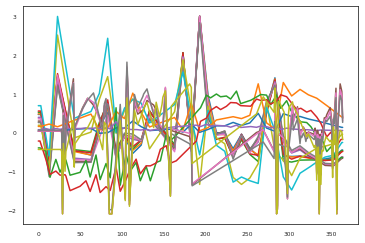

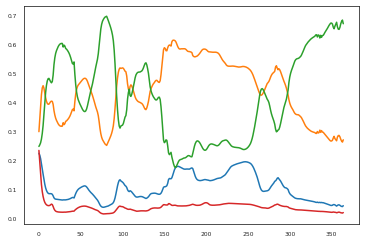

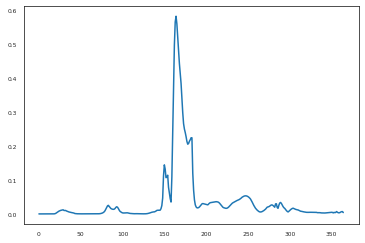

In [32]:
X,y, id = test_ds[4]
X = X.unsqueeze(0).to(args.device)
log_class_probabilities, probability_stopping = model(X)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X[0].cpu().detach())
plt.figure()
plt.plot(log_class_probabilities[0].cpu().detach().exp())
plt.figure()
plt.plot(probability_stopping[0].cpu().detach())

In [33]:
import numpy as np
from tqdm.notebook import tqdm
dataloader = DataLoader(test_ds, batch_size=16)
device = args.device
model.eval()

stats = []
losses = []
ids = []
for batch in tqdm(dataloader):
    X, y_true, ids_ = batch
    X, y_true = X.to(device), y_true.to(device)

    log_class_probabilities, probability_stopping, predictions_at_t_stop, t_stop = model.predict(X)
    stat = {}
    stat["probability_stopping"] = probability_stopping.cpu().detach().numpy()
    stat["class_probabilities"] = log_class_probabilities.exp().cpu().detach().numpy()
    stat["predictions_at_t_stop"] = predictions_at_t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["t_stop"] = t_stop.unsqueeze(-1).cpu().detach().numpy()
    stat["targets"] = y_true.cpu().detach().numpy()
    ids.append(ids_)

    stats.append(stat)


# list of dicts to dict of lists
stats = {k: np.vstack([dic[k] for dic in stats]) for k in stats[0]}
ids = np.hstack(ids)

y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]

  0%|          | 0/26 [00:00<?, ?it/s]

In [34]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_true, y_pred))

accuracy_score(y_true, y_pred)

              precision    recall  f1-score   support

           0       0.67      0.05      0.09        84
           1       0.53      0.91      0.67       202
           2       0.63      0.51      0.56        67
           3       1.00      0.02      0.04        56

    accuracy                           0.54       409
   macro avg       0.71      0.37      0.34       409
weighted avg       0.64      0.54      0.44       409



0.5427872860635696

In [35]:
if args.sequencelength == 365:
    doy_stop = stats["t_stop"][:,0]
else:
    doys_dict = test_ds.doys_dict

    doy_stop = []
    for id, t_stop in zip(ids, stats["t_stop"][:,0]):
        doys = doys_dict[id]
        t_stop = len(doys)-1 if t_stop > len(doys)-1 else t_stop
        doy_stop.append(doys_dict[id][t_stop])
    doy_stop = np.array(doy_stop)

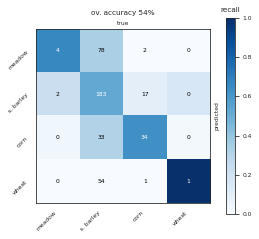

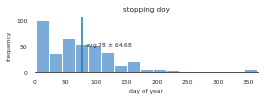

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn

labels_names = ["meadow", "s. barley", "corn", "wheat", "w. barley", "clover", "triticale"]
acier = "#4F8FCC"
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]


cm_norm = confusion_matrix(y_pred, y_true, normalize="true")
cm = confusion_matrix(y_pred, y_true)

fig, ax = plt.subplots(1,1, figsize=(4,4))

plt.rc("axes.spines", top=False, right=False, bottom=False, left=False)

ax.set_xticks(range(len(labels_names)))
ax.set_xticklabels(labels_names, rotation=45, ha="right")

ax.set_yticks(range(len(labels_names)))
ax.set_yticklabels(labels_names, rotation=45, ha="right")

im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm_norm[i,j] > 0.5 else "black"
        txt = str(cm[i,j])
        txt = txt[:-3] + "k" if len(txt) > 3 else txt
        ax.text(i,j, txt, ha="center", va="center", color=color)

cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.9, pad = 0.07)
cbar.ax.set_title('recall')

ax.yaxis.set_label_position("right")
ax.set_ylabel("predicted")
ax.xaxis.set_label_position("top")
ax.set_xlabel("true")


accuracy = accuracy_score(y_pred, y_true)
ax.set_title(f"ov. accuracy {accuracy*100:.0f}%")      
fig.savefig("/home/marc/Desktop/elects/ghana_confmat.pdf",dpi=300,bbox_inches='tight')
fig, ax = plt.subplots(1,1, figsize=(4,1))
        
seaborn.histplot(x=doy_stop,ax=ax, color=acier)
seaborn.despine(offset=0, left=True)
ax.set_xlabel("day of year")
ax.set_ylabel("frequency")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
#ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
#ax.set_xticks(doys)
ax.set_title(f"stopping doy")
ax.axvline(doy_stop.mean())
ax.text(doy_stop.mean()+5,50, f"avg {doy_stop.mean():.0f} $\pm$ {doy_stop.std():.2f}")
#ax.set_xticklabels(dates, rotation=20, ha='right')
fig.savefig("/home/marc/Desktop/elects/ghana_violin.pdf",dpi=300,bbox_inches='tight')

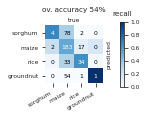

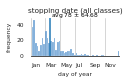

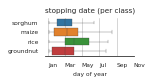

In [37]:

from sklearn.metrics import confusion_matrix, accuracy_score
import datetime

import seaborn
import matplotlib.pyplot as plt

import datetime

#doy_stop = t_stop[:,0]

pt2inch = 0.0138888889
textsize = 345 # pt
textsize_inch = textsize*pt2inch

plt.rc('font', size=6) 
plt.rc("axes.spines", top=False, right=False, bottom=False, left=False)


acier = "#4F8FCC"
y_pred = stats["predictions_at_t_stop"][:,0]
y_true = stats["targets"][:,0]


cm_norm = confusion_matrix(y_pred, y_true, normalize="true")
cm = confusion_matrix(y_pred, y_true)

fig, ax = plt.subplots(1,1, figsize=(textsize_inch*0.33,4))

labels_names = ['sorghum', 'maize', 'rice', 'groundnut']

ax.set_xticks(range(len(labels_names)))
ax.set_xticklabels(labels_names, rotation=30, ha="right")

ax.set_yticks(range(len(labels_names)))
ax.set_yticklabels(labels_names, rotation=0, ha="right")

im = ax.imshow(cm_norm, cmap="Blues", vmin=0, vmax=1)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        color = "white" if cm_norm[i,j] > 0.5 else "black"
        txt = str(cm[i,j])
        txt = txt[:-3] + "k" if len(txt) > 3 else txt
        ax.text(i,j, txt, ha="center", va="center", color=color)
        
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.3, pad = 0.2)
cbar.ax.set_title('recall')

ax.yaxis.set_label_position("right")
ax.set_ylabel("predicted")
ax.xaxis.set_label_position("top")
ax.set_xlabel("true")

ax.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,  
    left=True,# ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off


accuracy = accuracy_score(y_pred, y_true)
ax.set_title(f"ov. accuracy {accuracy*100:.0f}%")      
fig.savefig("/home/marc/Desktop/elects/ghana_confmat.pdf",dpi=300,bbox_inches='tight')

fig, ax = plt.subplots(1,1, figsize=(textsize_inch*0.33,0.7))
        
import seaborn
seaborn.set_style("white")

seaborn.histplot(x=doy_stop,ax=ax, color=acier, binwidth=7)
seaborn.despine(offset=0, left=True)
ax.set_xlabel("day of year")
ax.set_ylabel("frequency")
ax.set_xlim(0,365)
t = np.linspace(0,360,4)
#ax.set_ylim(-.5,1)
ys = [0.55,0.75,0.55,0.75]
#ax.set_xticks(doys)
ax.set_title(f"stopping date (all classes)")
ax.axvline(doy_stop.mean())
ax.text(doy_stop.mean()+5,50, f"avg {doy_stop.mean():.0f} $\pm$ {doy_stop.std():.2f}", color="black")
#ax.set_xticklabels(dates, rotation=20, ha='right')

doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13,2)]
months = ["Jan", "Mar", "May","Jul", "Sep", "Nov"]

ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")

fig.savefig("/home/marc/Desktop/elects/ghana_violin.pdf",dpi=300,bbox_inches='tight')


fig, ax = plt.subplots(figsize=(textsize_inch*0.33,0.7))
seaborn.boxplot(x=doy_stop,y=stats["targets"][:,0],orient="h",ax=ax,showfliers = False,linewidth=0.3)
ax.set_yticklabels(labels_names)
ax.set_xlabel("day of year")

doys_months = [datetime.datetime(2017,m,1).timetuple().tm_yday for m in range(1,13,2)]
months = ["Jan", "Mar", "May","Jul", "Sep", "Nov"]

ax.set_title(f"stopping date (per class)")
ax.xaxis.grid(True)
ax.set_xticks(doys_months)
ax.set_xticklabels(months, ha="left")


seaborn.despine(left=True)
fig.savefig("/home/marc/Desktop/elects/ghana_classearliness.pdf", transparent=True, bbox_inches="tight")

In [12]:
t_stop

tensor([74, 13], device='cuda:0')